## Baseline для задачи Sentiment analysis

Данный ноутбук может служить baselin-ом в соревновании https://www.kaggle.com/c/simplesentiment, также его можно использовать как базу для решения задачи анализа тональности текстов. 

В соревновании стоит задача прогнозирования по тексту отзыва его тональности: 1 - позитивная, 0 - негативная. 

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

### 1. Загрузка данных 

In [24]:
# Импортируем нужные билиотеки

import numpy as np
import pandas as pd
import warnings
import random
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
import seaborn as sns

warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style('whitegrid')
sns.set_palette('Set3')
random.seed(42)

In [3]:
# Считываем данные

train = pd.read_csv('simplesentiment/products_sentiment_train.tsv', names=['text', 'label'], header=0, sep='\t')
test = pd.read_csv('simplesentiment/products_sentiment_test.tsv', sep='\t')

X_train = train['text']
y_train = train['label']
X_test = test['text']
train.head()

,text,label
0,i downloaded a trial version of computer assoc...,1
1,the wrt54g plus the hga7t is a perfect solutio...,1
2,i dont especially like how music files are uns...,0
3,i was using the cheapie pail ... and it worked...,1
4,"you can manage your profile , change the contr...",1


### 2. Первичный анализ данных

In [4]:
print('Количество отзывов в train части:', X_train.shape[0])
print('Количество отзывов в test части:', X_test.shape[0])

Количество отзывов в train части: 1999
Количество отзывов в test части: 500


Проверим есть ли у нас расбалансировка классов в обучающей выборке.

% позитивных отзывов: 0.6368
% негативных отзывов: 0.3632
Количество позитивных отзывов: 1273
Количество негативных отзывов: 726


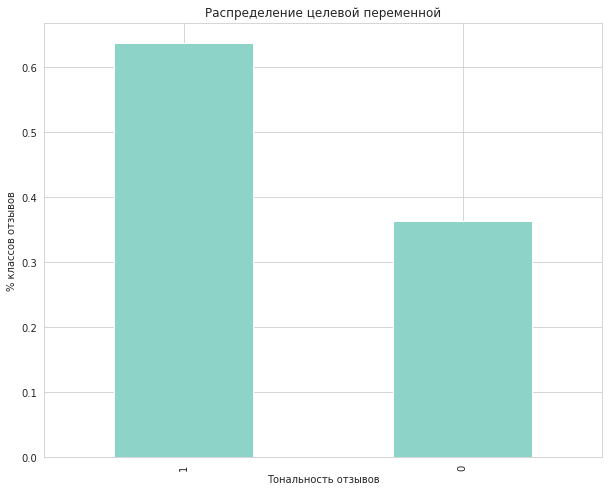

In [5]:
percent_of_pos_review = y_train.value_counts()[1] / y_train.shape[0]
percent_of_neg_review = y_train.value_counts()[0] / y_train.shape[0]


fig = plt.figure(figsize=(10, 8))
y_train.value_counts(normalize=True).plot(kind='bar')
plt.title('Распределение целевой переменной')
plt.xlabel('Тональность отзывов')
plt.ylabel('% классов отзывов')

print('% позитивных отзывов:', round(percent_of_pos_review, 4))
print('% негативных отзывов:', round(percent_of_neg_review, 4))
print('Количество позитивных отзывов:', y_train.value_counts()[1])
print('Количество негативных отзывов:', y_train.value_counts()[0])

Видно, что есть, поэтому это необходимо учитывать в будущем.

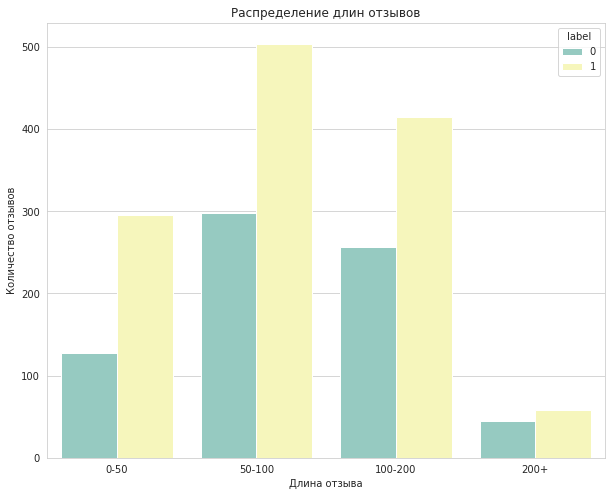

In [6]:
copy_train = train.copy()
copy_train['length of review'] = pd.cut(X_train.apply(lambda x: len(x)), 
                                        bins=[0, 50, 100, 200, float('inf')], 
                                        labels=['0-50', '50-100', '100-200', '200+'])
fig = plt.figure(figsize=(10, 8))
sns.countplot(data=copy_train, x='length of review', hue='label')
plt.title("Распределение длин отзывов")
plt.xlabel("Длина отзыва")
plt.ylabel("Количество отзывов");

### 3. Поиск оптимального baseline

Так как наша целевая переменная не сбалансирована, то добавим примерно половину (350) негативных отзывов и будем смотреть качество на кросвалидации всего на 2000 отзывов. Это сделано исходя из предположения, что излишний oversampling возможно будет ухудшать качество классификатора.

In [7]:
train_balanced = train.sort_values(by=['label']).iloc[:1800]
train_balanced.reset_index(drop=True, inplace=True)
train_balanced = shuffle(train_balanced.append(train_balanced.iloc[list(train_balanced.index[:350])]), random_state=10)

In [8]:
train_balanced['label'].value_counts()

0    1076
1    1074
Name: label, dtype: int64

In [9]:
X = train_balanced['text']
y = train_balanced['label']

In [10]:
def text_classifier(vectorizer, classifier):
    return Pipeline([('vectorizer', vectorizer), 
                     ('classifier', classifier)])

Посмотрим на дефолтные результаты разных классификаторов вместе с CountVectorizer.

In [11]:
warnings.filterwarnings('ignore')
list_of_algos = [LogisticRegression, LinearSVC, SGDClassifier,
                 MultinomialNB, RandomForestClassifier, GradientBoostingClassifier]
list_of_algos_str = ['LogisticRegression', 'LinearSVC', 'SGDClassifier',
                 'MultinomialNB', 'RandomForestClassifier', 'GradientBoostingClassifier']

for clf, clf_str  in zip(list_of_algos, list_of_algos_str):
    print(clf_str + ':', round(cross_val_score(text_classifier(CountVectorizer(), clf()), X, y).mean(), 5))
    print()

LogisticRegression: 0.8065

LinearSVC: 0.79395

SGDClassifier: 0.79302

MultinomialNB: 0.80185

RandomForestClassifier: 0.77674

GradientBoostingClassifier: 0.75535



Теперь посмотрим на дефолтные результаты разных классификаторов вместе с TfidfVectorizer.

In [12]:
warnings.filterwarnings('ignore')

for clf, clf_str  in zip(list_of_algos, list_of_algos_str):
    print(clf_str + ':', round(cross_val_score(text_classifier(TfidfVectorizer(), clf()), X, y).mean(), 5))
    print()

LogisticRegression: 0.79627

LinearSVC: 0.80836

SGDClassifier: 0.79581

MultinomialNB: 0.80325

RandomForestClassifier: 0.77116

GradientBoostingClassifier: 0.73721



Видно, что GradientBoosting и RandomForest, показывают результаты хуже, чем другие алгоритмы. В лидерах оказались MultinomialNB + CountVectorizer и TfidfVectorizer, LogisticRegression + CountVectorizer и LinearSVC + TfidfVectorizer.

Посмотрим на результаты с разными ngram-ами.

In [13]:
warnings.filterwarnings('ignore')

ngram_ranges = [(1,1), (1,2), (1,3), (2,2), (2,3), (3,3)]

for clf, clf_str  in zip(list_of_algos[:4], list_of_algos_str[:4]):
    for j in ngram_ranges:
        print(clf_str + ' + CountVect' ' ngram_range ' + str(j) +':', round(cross_val_score(text_classifier(CountVectorizer(ngram_range=j), clf()), X_train, y_train).mean(), 5))
        print()

LogisticRegression + CountVect ngram_range (1, 1): 0.77338

LogisticRegression + CountVect ngram_range (1, 2): 0.76938

LogisticRegression + CountVect ngram_range (1, 3): 0.76338

LogisticRegression + CountVect ngram_range (2, 2): 0.70385

LogisticRegression + CountVect ngram_range (2, 3): 0.69335

LogisticRegression + CountVect ngram_range (3, 3): 0.64482

LinearSVC + CountVect ngram_range (1, 1): 0.75087

LinearSVC + CountVect ngram_range (1, 2): 0.75937

LinearSVC + CountVect ngram_range (1, 3): 0.75588

LinearSVC + CountVect ngram_range (2, 2): 0.71636

LinearSVC + CountVect ngram_range (2, 3): 0.69634

LinearSVC + CountVect ngram_range (3, 3): 0.65383

SGDClassifier + CountVect ngram_range (1, 1): 0.74086

SGDClassifier + CountVect ngram_range (1, 2): 0.76388

SGDClassifier + CountVect ngram_range (1, 3): 0.76238

SGDClassifier + CountVect ngram_range (2, 2): 0.70687

SGDClassifier + CountVect ngram_range (2, 3): 0.71536

SGDClassifier + CountVect ngram_range (3, 3): 0.66733

Mult

In [14]:
warnings.filterwarnings('ignore')

for clf, clf_str  in zip(list_of_algos[:4], list_of_algos_str[:4]):
    for j in ngram_ranges:
        print(clf_str + ' + TF-IDF' ' ngram_range ' + str(j) +':', round(cross_val_score(text_classifier(TfidfVectorizer(ngram_range=j), clf()), X_train, y_train).mean(), 5))
        print()

LogisticRegression + TF-IDF ngram_range (1, 1): 0.75787

LogisticRegression + TF-IDF ngram_range (1, 2): 0.72986

LogisticRegression + TF-IDF ngram_range (1, 3): 0.71186

LogisticRegression + TF-IDF ngram_range (2, 2): 0.66383

LogisticRegression + TF-IDF ngram_range (2, 3): 0.65183

LogisticRegression + TF-IDF ngram_range (3, 3): 0.63882

LinearSVC + TF-IDF ngram_range (1, 1): 0.76788

LinearSVC + TF-IDF ngram_range (1, 2): 0.77988

LinearSVC + TF-IDF ngram_range (1, 3): 0.78338

LinearSVC + TF-IDF ngram_range (2, 2): 0.73887

LinearSVC + TF-IDF ngram_range (2, 3): 0.72387

LinearSVC + TF-IDF ngram_range (3, 3): 0.67684

SGDClassifier + TF-IDF ngram_range (1, 1): 0.75136

SGDClassifier + TF-IDF ngram_range (1, 2): 0.77839

SGDClassifier + TF-IDF ngram_range (1, 3): 0.78538

SGDClassifier + TF-IDF ngram_range (2, 2): 0.73437

SGDClassifier + TF-IDF ngram_range (2, 3): 0.74037

SGDClassifier + TF-IDF ngram_range (3, 3): 0.68233

MultinomialNB + TF-IDF ngram_range (1, 1): 0.69935

Multin

Подыщем теперь лучшие параметры для нашего классификатора на всей выборке с помощью GridSearchCV.

In [15]:
warnings.filterwarnings("ignore")

estimator = LogisticRegression(class_weight = {0:round(percent_of_pos_review, 4),
                                               1:round(percent_of_neg_review, 4)})

parameters = {'dual': [True, False], 'C': np.arange(1, 500, 10)}
vectorizer =  TfidfVectorizer(ngram_range=(1,2))
X_vect = vectorizer.fit_transform(X_train)
clf = GridSearchCV(estimator, parameters)
clf.fit(X_vect, y_train)
clf.best_estimator_

LogisticRegression(C=61, class_weight={0: 0.6368, 1: 0.3632}, dual=True,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Найдем более точное значение.

In [16]:
warnings.filterwarnings("ignore")
estimator = LogisticRegression(class_weight = {0:round(percent_of_pos_review, 4),
                                               1:round(percent_of_neg_review, 4)}, dual=True)


parameters = {'C': np.arange(40, 70, 1)}
clf = GridSearchCV(estimator, parameters)
clf.fit(X_vect, y_train)
clf.best_estimator_

LogisticRegression(C=55, class_weight={0: 0.6368, 1: 0.3632}, dual=True,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

#### Сабмит решения.

In [17]:
clf_ = LogisticRegression(class_weight={0:0.636, 1:0.364}, C=55, dual=True)
#clf_ = LinearSVC(class_weight = {0:0.636, 1:0.364})


clf_.fit(X_vect, y_train)
X_test_vect = vectorizer.transform(X_test)
predict_vector = clf_.predict(X_test_vect)
data_predict = pd.DataFrame({'Id': list(range(0, len(predict_vector))),'y': predict_vector})
data_predict.to_csv(r'santiment.csv', index = None, header=True)
export_csv = data_predict.to_csv(r'santiment.csv', index = None, header=True) 

#### Сохранение классификатора и векторайзера.

In [18]:
import pickle

with open('./TextSentiment.pkl', 'wb') as handle:
    pickle.dump(clf_, handle)
with open('./Vectorizer.pkl', 'wb') as handle:
    pickle.dump(vectorizer, handle)

### 4. Возможные улучшения

Как вариант можно посмотреть на списки самых популярных (с наибольшим весом) позитивных и негативных слов и сотавить из них стоп лист.

In [19]:
vect_val = list(vectorizer.vocabulary_.values())
vect_key = list(vectorizer.vocabulary_.keys())

vect_vocab_reverse = {val:key  for val, key in zip (vect_val, vect_key)}

coef_lr_list = clf_.coef_[0,:]

top_pos = []
top_neg = []

for i in range(15):
    top_pos.append(np.argmax(coef_lr_list))
    top_neg.append(np.argmin(coef_lr_list))
    coef_lr_list = np.delete(coef_lr_list, np.argmax(coef_lr_list))
    coef_lr_list = np.delete(coef_lr_list, np.argmin(coef_lr_list))

top_pos = [vect_vocab_reverse[i] for i in top_pos]
top_neg = [vect_vocab_reverse[i] for i in top_neg]

In [20]:
top_pos

['great',
 'and',
 'gonna go',
 'easily worked',
 'loud that',
 'excelent',
 'previous',
 'you value',
 'feature so',
 'weeks this',
 'usb and',
 'convinced',
 'hang of',
 'the plastic',
 'people using']

In [21]:
top_neg

['only',
 'nose for',
 'worthwile at',
 'after',
 'normalization',
 'these other',
 'understand and',
 'annoy',
 'used this',
 'button suprisingly',
 'does load',
 'business you',
 'pro',
 'is minimum',
 'someone asked']

In [22]:
my_stop_list = ['only', 'after', 'and', 'button', 'this']

In [23]:
clf_regression = LogisticRegression(class_weight = {0:round(percent_of_pos_review, 4),
                                                   1:round(percent_of_neg_review, 4)}, C=55, dual=True)

vectorizer =  TfidfVectorizer(ngram_range=(1,2), stop_words=my_stop_list)
X_vect = vectorizer.fit_transform(X_train)
clf_regression.fit(X_vect, y_train)
X_test = vectorizer.transform(X_test)
predict_vector = clf_regression.predict(X_test)
data_predict = pd.DataFrame({'Id': list(range(0, len(predict_vector))),'y': predict_vector})
data_predict.to_csv(r'santiment_stop_list.csv', index = None, header=True)
export_csv = data_predict.to_csv(r'santiment_stop_list.csv', index = None, header=True)

Однако данный подход не улучшает качество на тестовой выборке.